In [1]:
import sys
sys.path.append('../')  # To ensure utils can be imported if needed

%load_ext autoreload
%autoreload 2

In [16]:
import pickle
import os

target_directory = "../data/grow/"  # Adjust path if needed
file_to_exclude = "chains_raw.pkl"

files_to_process = [
    os.path.join(target_directory, f)
    for f in os.listdir(target_directory)
    if f.endswith(".pkl") and f != file_to_exclude
]

for file_name in files_to_process:
    with open(file_name, "rb") as f:
        data = pickle.load(f)

    for item in data:
        item["multihop_answer"] = item["triples"][-1]["triple_label"][-1]
        for i, probe_question in enumerate(item["probe_questions"]):
            probe_question["answer"] = item["triples"][i]["triple_label"][-1]

    with open(file_name, "wb") as f:
        pickle.dump(data, f)

In [2]:
import pickle
import os

with open("../data/grow/chains_llama-3.2-3b-turbo_exp_f.pkl", "rb") as f:
    data = pickle.load(f)

In [7]:
data = data[:5]

import json
from tqdm import tqdm
from utils.evaluator import CotEvaluator
class Args:
    def __init__(self):
        self.model_name = "gpt-4o-mini"
args = Args()
with open("../api_key/config.json", 'r') as f:
    api_config = json.load(f)
    args.api_key = api_config.get("api_key", None)
cot_evaluator = CotEvaluator(args)
for item in tqdm(data):
    item["model_answers_correct"] = [cot_evaluator.answer_evaluator_cot(item["multihop_questions"][i], response, item["multihop_answer"]) for i, response in enumerate(item["model_answers"])]
    item["model_answers_correct_after_injection"] = [cot_evaluator.answer_evaluator_cot(item["multihop_questions"][i], response, item["multihop_answer"]) for i, response in enumerate(item["model_answers_after_injection"])]
    item["model_probe_answers_correct"] = [[cot_evaluator.answer_evaluator_cot(item["probe_questions"][i]["question"], response, item["probe_questions"][i]["answer"]) for response in ans_list] for i, ans_list in enumerate(item["model_probe_answers"])]

100%|██████████| 5/5 [07:03<00:00, 84.76s/it]


In [9]:
data

[{'triples': [{'triple': ('Q102400597', 'P69', 'Q1190812'),
    'triple_label': ('Xi Ronald Chen',
     'educated at',
     'University of New Mexico')},
   {'triple': ('Q1190812', 'P159', 'Q34804'),
    'triple_label': ('University of New Mexico',
     'headquarters location',
     'Albuquerque')},
   {'triple': ('Q34804', 'P6', 'Q7807370'),
    'triple_label': ('Albuquerque',
     'head of government',
     'Timothy M. Keller')},
   {'triple': ('Q7807370', 'P27', 'Q30'),
    'triple_label': ('Timothy M. Keller',
     'country of citizenship',
     'United States')},
   {'triple': ('Q30', 'P35', 'Q22686'),
    'triple_label': ('United States', 'head of state', 'Donald Trump')}],
  'probe_questions': [{'question': 'Which university was Xi Ronald Chen educated at?',
    'cloze': 'The univeristy where Xi Ronald Chen was educated is ___',
    'answer': 'University of New Mexico'},
   {'question': 'Which city is the headquarter of University of New Mexico located in?',
    'cloze': 'The he

In [ ]:
# Filter original incorrect, knowledge incorrect
filtered_data = []

for item in data:
    filtered_model_answers_correct = []
    filtered_multihop_questions = []
    filtered_model_answers = []
    if "Unknown" not in item["model_probe_knowledge_confidence"]:
        continue
    for i, answer in enumerate(item["model_answers"]):
        if item["model_answers_correct"][i] == True:
            continue
        filtered_model_answers_correct.append(item["model_answers_correct"][i])
        filtered_multihop_questions.append(item["multihop_questions"][i])
        filtered_model_answers.append(answer.split("\n")[-1])
    if len(filtered_model_answers_correct) == 0:
        continue
    item["model_answers_correct"] = filtered_model_answers_correct
    item["multihop_questions"] = filtered_multihop_questions
    item["model_answers"] = filtered_model_answers
    filtered_data.append(item)

In [6]:
filtered_data[0]

{'triples': [{'triple': ('Q102400597', 'P69', 'Q1190812'),
   'triple_label': ('Xi Ronald Chen',
    'educated at',
    'University of New Mexico')},
  {'triple': ('Q1190812', 'P159', 'Q34804'),
   'triple_label': ('University of New Mexico',
    'headquarters location',
    'Albuquerque')},
  {'triple': ('Q34804', 'P6', 'Q7807370'),
   'triple_label': ('Albuquerque', 'head of government', 'Timothy M. Keller')},
  {'triple': ('Q7807370', 'P27', 'Q30'),
   'triple_label': ('Timothy M. Keller',
    'country of citizenship',
    'United States')},
  {'triple': ('Q30', 'P35', 'Q22686'),
   'triple_label': ('United States', 'head of state', 'Donald Trump')}],
 'probe_questions': [{'question': 'Which university was Xi Ronald Chen educated at?',
   'cloze': 'The univeristy where Xi Ronald Chen was educated is ___',
   'answers': ['University of New Mexico',
    'unm.edu',
    'The University of New Mexico',
    'Universitatis Novus Mexico',
    'U.N.M.',
    'Univ. of New Mexico',
    'State 

In [5]:
data[0]

{'triples': [{'triple': ('Q102400597', 'P69', 'Q1190812'),
   'triple_label': ('Xi Ronald Chen',
    'educated at',
    'University of New Mexico')},
  {'triple': ('Q1190812', 'P159', 'Q34804'),
   'triple_label': ('University of New Mexico',
    'headquarters location',
    'Albuquerque')},
  {'triple': ('Q34804', 'P6', 'Q7807370'),
   'triple_label': ('Albuquerque', 'head of government', 'Timothy M. Keller')},
  {'triple': ('Q7807370', 'P27', 'Q30'),
   'triple_label': ('Timothy M. Keller',
    'country of citizenship',
    'United States')},
  {'triple': ('Q30', 'P35', 'Q22686'),
   'triple_label': ('United States', 'head of state', 'Donald Trump')}],
 'probe_questions': [{'question': 'Which university was Xi Ronald Chen educated at?',
   'cloze': 'The univeristy where Xi Ronald Chen was educated is ___',
   'answer': 'University of New Mexico'},
  {'question': 'Which city is the headquarter of University of New Mexico located in?',
   'cloze': 'The headquarters of University of New

<BarContainer object of 4 artists>

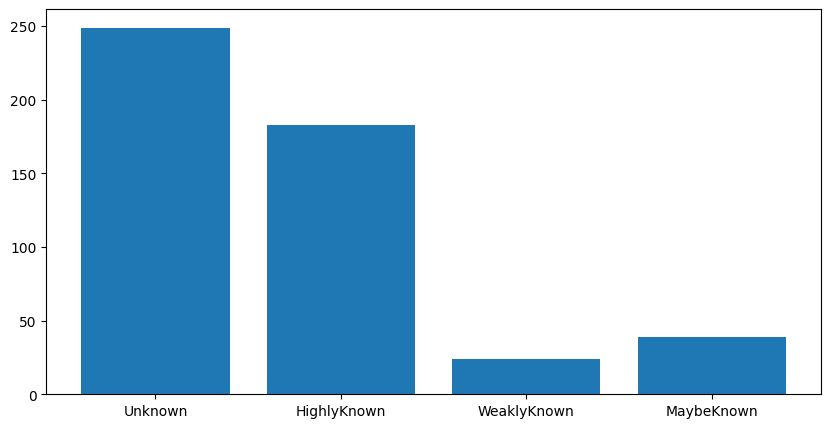

In [3]:
# Print the histogram of knowledge confidence
import matplotlib.pyplot as plt
from collections import Counter

confidence_counts = Counter()
for item in data:
    for confidence in item["model_probe_knowledge_confidence"]:
        confidence_counts[confidence] += 1
        
# Plot the histogram
plt.figure(figsize=(10, 5))
plt.bar(confidence_counts.keys(), confidence_counts.values())